# Classify architecture type from an image of a home

In [2]:
# Need to run `PYTORCH_ENABLE_MPS_FALLBACK=1 jupyter notebook` before loading this notebook
# there is an error that pops up later with augmentation that I couldn't figure out how to change while in the notebook.

# Suppress warnings from PyTorch
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# fastai V1 library which sits on top of Pytorch 1.0
from fastai.vision import *

import requests

from bs4 import BeautifulSoup

from fastai.vision.all import *
from fastai.vision import *

# import my custom functions
from src.utils import _label_func

import pandas as pd
import matplotlib.pyplot as plt



## Look at results

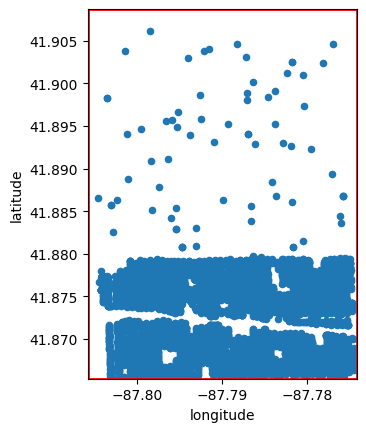

In [3]:
# now I need to find out how to extract data...
# soup.contents

# ok- thinking about this
# according to xx there are 25000 homes in Oak Park
# on redfin, there are ~3000 in last 5 years

# TODO make sure my scraping script is outputting home metadata correctly

# load redfin metadata
rf_metadata = pd.read_csv('data/interim/redfin_metadata.csv')

# Fill NaN values with a placeholder integer (e.g., -1)
rf_metadata['property_id'] = rf_metadata['property_id'].fillna(-1).astype(int)

# Google maps coordinates of bounding box for Oak Park
uleft = 41.90872286303018, -87.80575098756486
lright = 41.86533629647352, -87.7741652965275

# Filter out homes that are not in Oak Park (based on google maps coordinates)
rf_metadata['in_oak_park'] = [1 if x['latitude'] < uleft[0] and x['latitude'] > lright[0] and x['longitude'] < lright[1] and x['longitude'] > uleft[1] else 0 for x in rf_metadata.to_dict(orient='records')]
rf_metadata = rf_metadata[rf_metadata['in_oak_park'] == 1]

# Plot the latitude and longitude of the homes
rf_metadata.plot(kind='scatter', x='longitude', y='latitude')

# Draw rectangle for Oak Park
plt.gca().add_patch(plt.Rectangle((uleft[1], lright[0]), lright[1] - uleft[1], uleft[0] - lright[0], 
                                  edgecolor='r', facecolor='none', lw=2))

plt.xlim(min(rf_metadata['longitude'].min(), uleft[1]), max(rf_metadata['longitude'].max(), lright[1]))
plt.ylim(min(rf_metadata['latitude'].min(), lright[0]), max(rf_metadata['latitude'].max(), uleft[0]))

plt.gca().set_aspect('equal', adjustable='box')

## House image classifier

### Image loading setup

In [4]:
# get images for training the model
path = "/Users/chad/github/architecture/images/training"
fnames = get_image_files(path)

len(fnames) # 65 images


65

### Use image augmentation to increase training samples

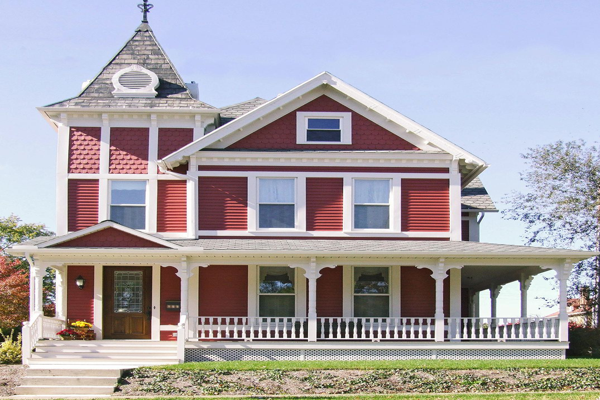

In [7]:
# single image of a house
img = PILImage(PILImage.create(fnames[0]).resize((600,400)))
img

In [8]:
# tensor.. ?
timg = TensorImage(array(img)).permute(2,0,1).float()/255.

In [9]:
# setup augmentation transforms of image
tfms = aug_transforms(pad_mode='zeros', mult=2, min_scale=0.75, do_flip=True, flip_vert=False, max_rotate=3, max_zoom=1.1,
                     max_lighting=0.2, max_warp=0.1, p_affine=0.75, p_lighting=0.5)

# NB: I took these parameters from an existing project on github-
# https://github.com/dumitrux/architectural-style-recognition/blob/master/src/architectural-style-recognition.ipynb
# tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, 
#                       max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
# NB: this get_transforms function is for the old fastai/pytorch versions so now I needed to use aug_transforms, as above


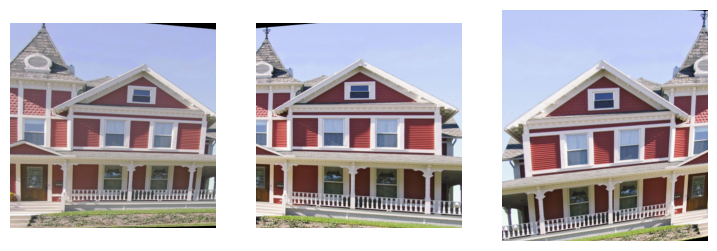

In [10]:
from fastai.vision.all import TensorImage

def _batch_ex(bs):
    return TensorImage(timg[None].expand(bs, *timg.shape).clone())

# plot some sample transformations
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(1,3, figsize=(9,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

# save this image to a file
plt.axis('tight')
plt.savefig('reports/figures/warp.jpg')


In [11]:
# this way was using cap letter as labeler
# dls = ImageDataLoaders.from_name_func(path, files, label_func, bs=5, item_tfms=Resize(224), valid_pct=0.2)
# valid_pct is the percent of images used for validation

# this pulls the label from the file name (stuff before _ or -)
# dls = ImageDataLoaders.from_name_re(path, files, pat='^(.*)[_-].*?.jpg', item_tfms=Resize(224), bs=5)

# trying datablock instead
# here the subfolder name is used as the label
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(valid_pct=0.2, seed=44),
                   item_tfms = Resize(224),
                   batch_tfms = tfms)

# does this help anything?
# batch_tfms = aug_transforms(size=224)
# load the data (batch size 5 minimum)
dls = dblock.dataloaders(path, bs=12)

/Users/chad/github/architecture/env/lib/python3.10/site-packages/torch/_tensor.py:1437: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


NB: this spits out a pytorch warning, but it seems to work still

In [12]:
# show the data
'train:', len(dls.train.items), 'valid:', len(dls.valid.items)

('train:', 52, 'valid:', 13)

In [13]:
print("Training images:\n", [x.stem for x in dls.train.items], "\n")
print("Validation images:\n", [x.stem for x in dls.valid.items])

Training images:
 ['red-victorian-home-wrap-around-porch-964fcce8-6d2ab8ee6f5b4d79941bd8866d1fb9ec', 'detroitbungalow_edited', 'prairie_410NElmwoodAve', '5E39127F-AA2D-456F-BB60-D3AC619AE854', 'StuccoFourSquare', 'bungalow-484149133', '001-1024x680', 'GettyImages-160808926-8259f31f8e924329bf7bc59c0f6e89dc', 'XL_21561_Jones_Listing_201_Market_Street_Bvillle_013', 'Foursquare_1016ElginAve', 'prairie_1624W100thPl', 'main3', 'Foursquare-613SGrove', 'Foursquare_330SLombardAve', 'chicagobungalow4', 'mqa946mcv8m61', '674b8fda13b2840a27e796dc69f82254', '2449FourSquare', 'XL_16916_Front', 'prairie_1712W104thPl', 'GettyImages-165432736-scaled', 'victorian_654NCentralAve', 'main4_prairie-1024x768', '2928FourSquare', 'bungalow_1218Rossell', 'chicagobungalow8', 'Stock-Small-Bungalow-Home-Exterior-AdobeStock_361162520-copy', 'portland-foursquare-home', 'chicagobungalow3', 'stuccobungalow2', 'Foursquare_724SElmwoodAve', '6891-prairie-style-home-chicago', 'americanfoursquare', 'bungalow_932NOakParkAve

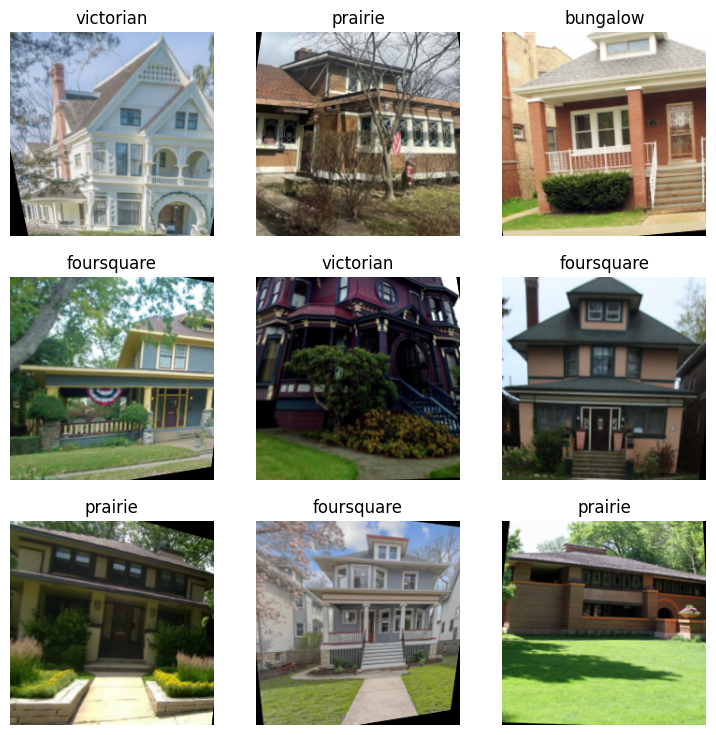

In [14]:
dls.show_batch()

In [15]:
# train the model
learn = vision_learner(dls, resnet34, metrics=error_rate)

# NB this was using ~6 cores on my local machine (macbook)

SuggestedLRs(valley=5.248074739938602e-05)

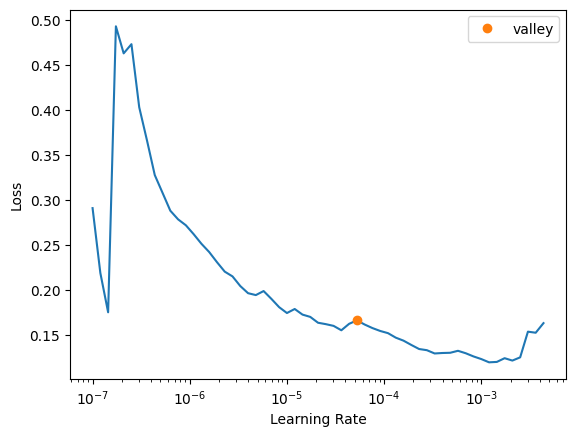

In [126]:
# ?? find optimal parameters for fine-tuning the model
# Find optimal learning rate
learn.lr_find()


In [127]:
# fine tune the learner
learn.fine_tune(15, 5.25e-5)

Getting pretty decent performance (~85% accuracy) with only this very limited image set

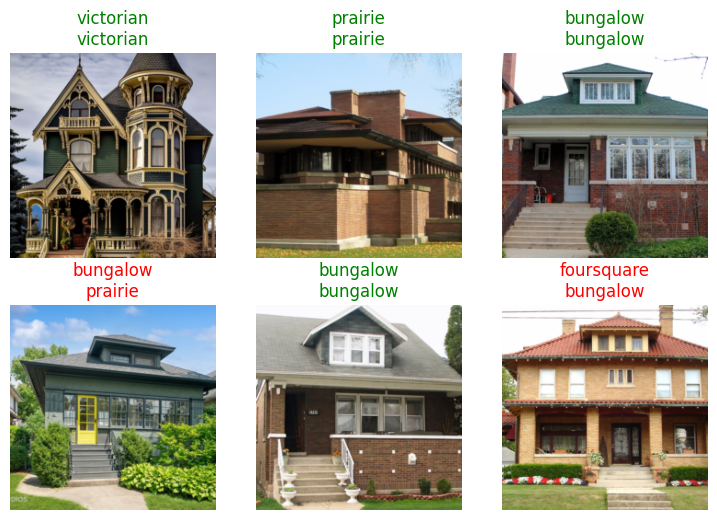

In [129]:
learn.show_results(max_n=6)
plt.savefig('reports/figures/learn_results.png')

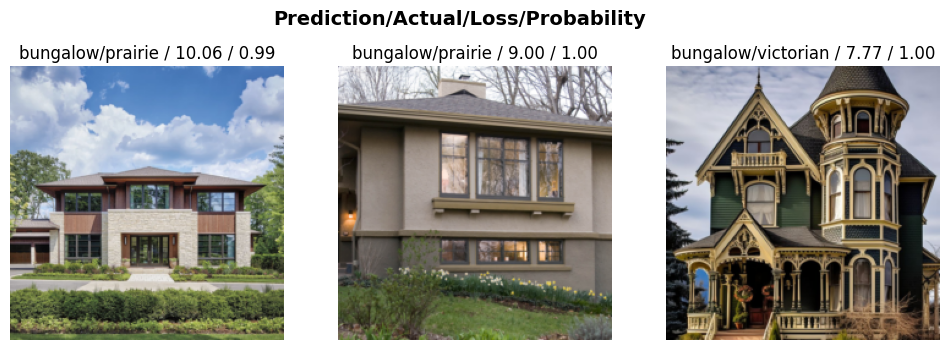

In [16]:
# find the images that give the most problems
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(3, figsize=(12,4))

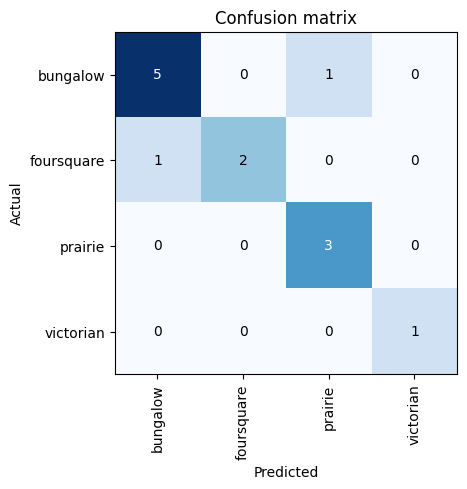

In [141]:
# look at confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.savefig('reports/figures/confusion_matrix.png')

From this, we can see that bungalows, foursquares, and prairie-style homes all kind of blend together.

### Save the model

In [45]:
learn.save('architecture_model')

Path('models/architecture_model.pth')

## Predicting home types

### Using the trained model to predict house type from redfin images

In [17]:
# NB: takes 3 minutes for all 5000 images

import os
import pandas as pd

learn.load('architecture_model')

# Get list of file paths to the test images
test_images = get_image_files('images/testing')

df_preds = pd.DataFrame(columns=['image', 'prediction', 'probability'])

# Load and predict on each test image
for img_path in test_images:

    img = PILImage.create(img_path)

    pred, _, probs = learn.predict(img)

    # Get the basename of the first test image path
    nm = os.path.basename(img_path)
    df = pd.DataFrame({'image': nm, 'prediction': pred, 'probability': probs.max().item()}, index=[0])
    df_preds = pd.concat([df_preds, df])

df_preds['pid'] = df_preds['image'].str.extract(r'pid(\d+)', expand=False)

df_preds.pid = df_preds.pid.astype(int)



/Users/chad/github/architecture/env/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=de

/var/folders/68/dksmh04d2l37ttl9pc9k553m0000gp/T/ipykernel_38391/3203636320.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_preds = pd.concat([df_preds, df])


array([[<Axes: title={'center': 'probability'}>]], dtype=object)

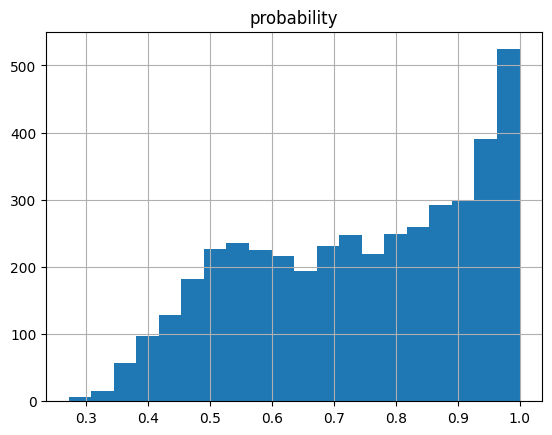

In [18]:
df_preds.hist(column='probability', bins=20)
# df_preds.boxplot(column='probability', by='prediction')


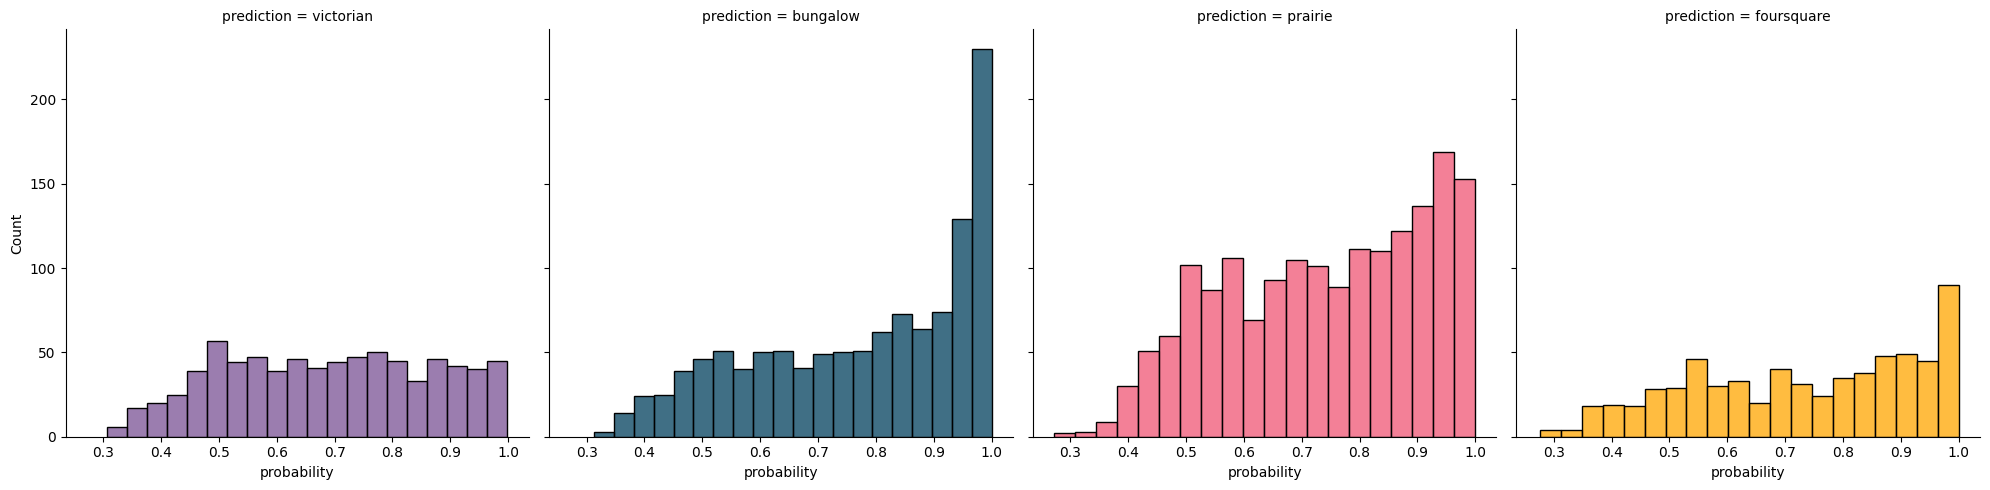

In [182]:
import seaborn as sns

# Get color classes for plotting later
prediction_colors = {'bungalow': '#003f5c', 'victorian': '#7a5195', 'prairie': '#ef5675', 'foursquare': '#ffa600'}

g = sns.FacetGrid(data=df_preds, col='prediction', col_wrap=4, height=5, hue='prediction', palette=prediction_colors)

g.map(sns.histplot, 'probability', bins=20, kde=False)
plt.savefig('reports/figures/probability_hist.png')


### Create map of architectural diversity by block

In [21]:
import seaborn as sns

# TODO plot a heatmap of the architectural diveristy by neighborhood

# Extract the relevant part of the image name using regex
# df_preds['extracted'] = df_preds['image'].str.extract(r'(\d+-\w+-\w+-\w+)', expand=False)
# df_preds['extracted'].values[0]

df_merged = df_preds.merge(rf_metadata, left_on='pid', right_on='property_id')

# TODO calculate architecture diversity by neighborhood

# Plot scatter of latitude and longitude with color as prediction
# sns.scatterplot(data=df_merged, x='longitude', y='latitude', hue='prediction')

In [32]:
df_merged[['latitude', 'longitude']].values

array([[ 41.8701352, -87.7819634],
       [ 41.8692376, -87.7776719],
       [ 41.8665857, -87.7781457],
       ...,
       [ 41.8666645, -87.7879841],
       [ 41.8687325, -87.7896868],
       [ 41.8658281, -87.7886198]])

<Axes: >

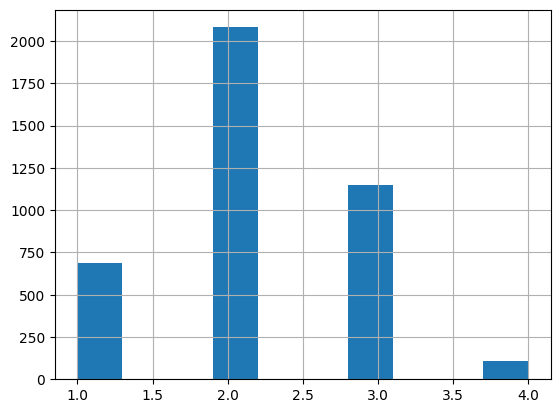

In [205]:
# Count up the number of distinct houses in a given radius

from sklearn.neighbors import NearestNeighbors

# conversion from meters to degrees
# 1 degree of latitude = 111 km
# assuming homes are 10 meters apart, 10/111000 = 0.00009 degrees

# Define the radius (in degrees, approximate for small distances)
radius = 0.0002  # adjust if needed, this is about 20 meters

# Initialize NearestNeighbors with the specified radius
nbrs = NearestNeighbors(radius=radius)

# Fit the model using latitude and longitude values for homes
nbrs.fit(df_merged[['latitude', 'longitude']].values)

# Function to calc. number of unique home types in a given radius
def count_unique_predictions_within_radius(row):
    # Find nearest neighbors within the radius
    indices = nbrs.radius_neighbors([row[['latitude', 'longitude']]], return_distance=False)[0]
    # Get the unique predictions
    unique_predictions = df_merged.iloc[indices]['prediction'].unique()
    return len(unique_predictions)

# Now we can apply the function to each row in the data frame-
df_merged['unique_predictions_in_radius'] = df_merged.apply(count_unique_predictions_within_radius, axis=1)

df_merged['unique_predictions_in_radius'].hist()

In [206]:
from scipy.interpolate import griddata
import numpy as np

import matplotlib.pyplot as plt

# Assuming x, y, and z are already defined
x = df_merged['longitude'].values
y = df_merged['latitude'].values
z = df_merged['unique_predictions_in_radius'].values
# z = np.hypot(x, y)  # Example z values, replace with actual data

# Define grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolate using griddata
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')


In [36]:
# Load roads

import geopandas as gpd

# Import all roads NL
map_df = gpd.read_file('data/raw/roads/Street_Centerlines.shp')

# Convert from meters to lat/long
map_df = map_df.to_crs(epsg=4326)

In [207]:
# Remove apartments and condos
df_merged = df_merged[~df_merged['match'].str.contains('Unit|#')]

df_merged['prediction'].value_counts()

prediction
prairie       1608
bungalow      1126
victorian      683
foursquare     611
Name: count, dtype: int64

interpolation

summary stats

### Mapping "alpha" diversity of architectural styles
In this section, we will create a heatmap plot to visualize the density of different architectural styles in Oak Park, IL. This type of plot helps in understanding the spatial distribution and density of various house types in the area. Note: I am using the concept of alpha diversity borrowed from the field of ecology. The idea is that in a given 30m radius, diversity is the number of unique home styles in that area.

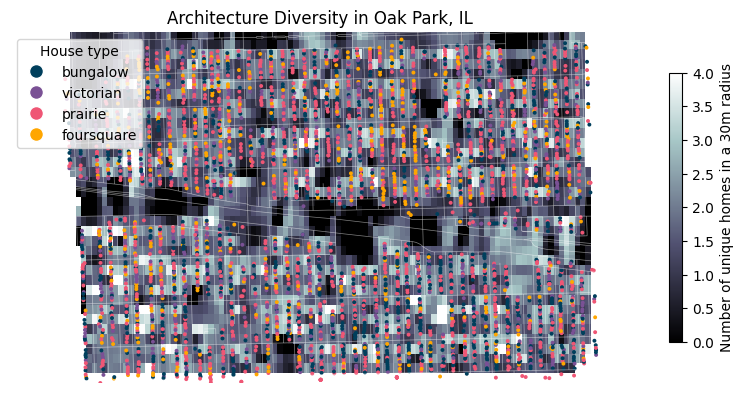

In [208]:

fig, ax = plt.subplots(1, figsize=(10,14))

# Define colors for each house type
prediction_colors = {'bungalow': '#003f5c', 'victorian': '#7a5195', 'prairie': '#ef5675', 'foursquare': '#ffa600'}

# Plot the interpolated data
plt.imshow(grid_z.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='bone', vmin=0, vmax=df_merged['unique_predictions_in_radius'].max())

# Add a color bar
cbar = plt.colorbar(label='Number of unique homes in a 30m radius', shrink=0.25)

# Map predictions to categorical color values
colors = df_merged['prediction'].map(prediction_colors)

# Add roads
map_df.plot(ax=ax, color='w', linewidth=0.5, alpha=0.5)

# Scatter plot with categorical colors of predicted home types
plt.scatter(x, y, c=colors, edgecolors='k', linewidths=0, s=8)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Set the title
plt.title('Architecture Diversity in Oak Park, IL')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in prediction_colors.items()]

plt.legend(handles=handles, title="House type")

# Turn off the axis
plt.axis('off')

# plt.ylim(min(y), max(y))
plt.ylim(min(y), 41.88)

# Save the plot
plt.savefig('reports/figures/architecture_diversity.png', dpi=300, bbox_inches='tight')

# Find lat/long associated with a given address
# tmp = df_merged[df_merged['input'].str.contains('626 S OAK PARK')]
# plt.scatter(tmp['longitude'], tmp['latitude'], c='b', edgecolors='w', linewidths=1, s=100)




<Axes: xlabel='prediction', ylabel='home_value'>

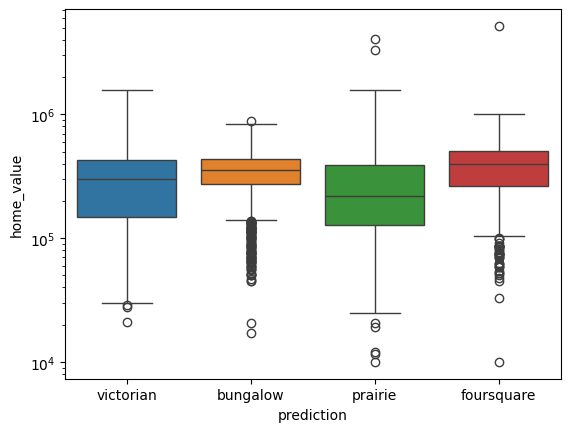

In [58]:
sns.boxplot(data=df_merged, x='prediction', y='home_value', hue='prediction', legend=False, log_scale=True)

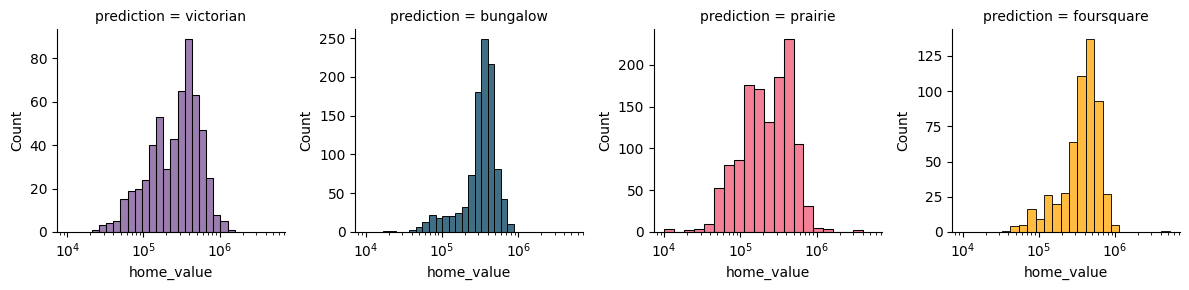

In [179]:
# Plot histograms of home values for each prediction
g = sns.FacetGrid(df_merged, col='prediction', col_wrap=4, sharey=False, hue='prediction', palette=prediction_colors)
g.map(sns.histplot, 'home_value', bins=20, log_scale=True)

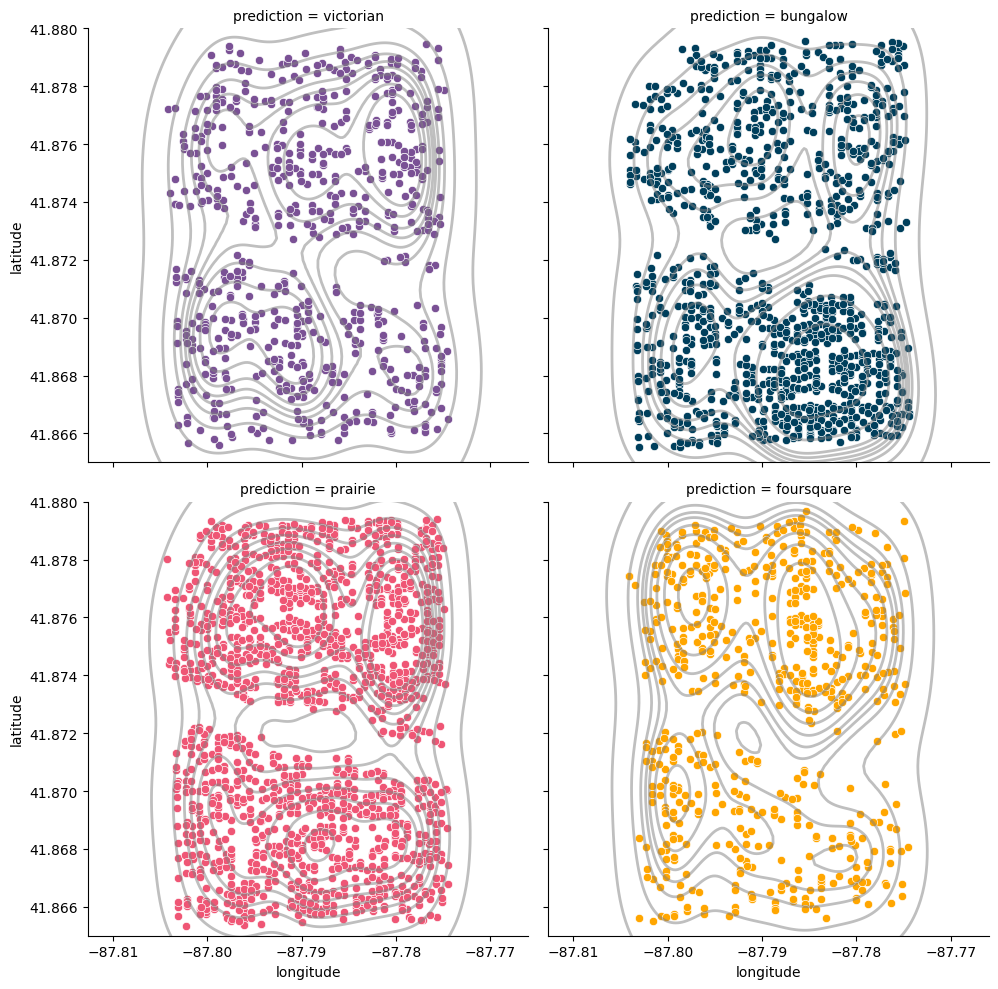

In [202]:
# Plot the distribution of different architectural home styles

g = sns.FacetGrid(df_merged, col='prediction', col_wrap=2, height=5, hue='prediction', palette=prediction_colors)

g.map(sns.scatterplot, 'longitude', 'latitude')
g.map(sns.kdeplot, 'longitude', 'latitude', levels=10, color='gray', linewidths=2, alpha=0.5)

g.set(ylim=(41.865, 41.88))


In [111]:
df_merged['home_value'].notna().sum()
# 3401 homes have home values.. cool

3401